This notebook tunes different logistic regression classification models with Optuna. 

The input to the model differs in the following ways:
- Vectorization is done with CountVectorizer
- Vectorization is done with TfIdfVectorizer
- Vectorization is done by making document vectors by averaging over pretrained word embeddings from Gensim
- Vectorization is done by making document vectors, but before averaging over the pretrained word embeddings, scale the embeddings by multiplying the with the TfIdf weights.

The output (labels) differs in the following ways:
- To get the label Male/Female there must be at least 60% of the applicants that are male/female. Otherwise label is Neutral.
- To get the label Male/Female there must be at least 70% of the applicants that are male/female. Otherwise label is Neutral.

The best results with no word embeddings (86% accuracy) were gotten with input that was vectorized with TfIdf and with a 70/30 distribution for the labels.

The best results with word embeddings(91% accuracy) were gotten with input that had document vectors made from TfIdf-scaled word embeddings and with a 70/30 distribution for the labels.

In [3]:
import os
os.chdir(r"c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination")
import warnings

import gensim
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

c:\Users\britt\Desktop\YH\Applicerad AI\job_discrimination_sandbox\venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
warnings.simplefilter("ignore")

In [5]:
df = pd.read_csv("data/cleaned_data/bulletins_w_labels_and_content.csv", dtype={'ID': object})  
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,Label 60/40,Numeric label 60/40,Label 70/30,Numeric label 70/30,Cleaned text,Text
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206 041814.txt,M,2,N,0,director class code open date annual salary du...,311 DIRECTOR Class Code: 9206 Open Date:...
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223 071318.txt,W,1,W,1,accounting clerk class code open date exam ope...,ACCOUNTING CLERK Class Code: 1223 Open ...
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260 120216.txt,M,2,M,2,airport manager class code open date exam open...,AIRPORT MANAGER Class Code: 7260 Open D...
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227 091616.txt,M,2,M,2,airport police lieutenant class code open date...,AIRPORT POLICE LIEUTENANT ...
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400 050214.txt,M,2,N,0,aquarist class code open date annual salary ca...,AQUARIST Class Code: 2400 Open Date: 05...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...,M,2,N,0,wastewater treatment laboratory manager class ...,WASTEWATER TREATMENT LABORATORY MANAGER Class...
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 120718.txt,M,2,M,2,wastewater treatment operator class code open ...,WASTEWATER TREATMENT OPERATOR Class Code: ...
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857 072514 rev073114.txt,N,0,N,0,water microbiologist class code open date revi...,WATER MICROBIOLOGIST Class Code: 7857...
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912 120817.txt,M,2,M,2,water utility worker class code open date exam...,WATER UTILITY WORKER Class Code: 3912 Op...


In [6]:
X = df["Cleaned text"]

In [7]:
count_vectorizer = CountVectorizer()
tfidf_vectorizer = TfidfVectorizer()

count_vectorizer_bigrams = CountVectorizer(ngram_range=(2, 2))
count_vectorizer_trigrams = CountVectorizer(ngram_range=(3, 3))

tfidf_vectorizer_bigrams = TfidfVectorizer(ngram_range=(2, 2))
tfidf_vectorizer_trigrams = TfidfVectorizer(ngram_range=(3, 3))

In [8]:
X_count = count_vectorizer.fit_transform(X).toarray()
X_tfidf = tfidf_vectorizer.fit_transform(X).toarray()

X_count_bigrams = count_vectorizer_bigrams.fit_transform(X).toarray()
X_count_trigrams = count_vectorizer_trigrams.fit_transform(X).toarray()

X_tfidf_bigrams = tfidf_vectorizer_bigrams.fit_transform(X).toarray()
X_tfidf_trigrams = tfidf_vectorizer_trigrams.fit_transform(X).toarray()

In [9]:
y_70_30 = df["Numeric label 70/30"]
y_60_40 = df["Numeric label 60/40"]

In [10]:
trials_dictionaries = []

In [13]:
def objective(trial):
    X = X_count
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [14]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-13 11:06:47,658] A new study created in memory with name: no-name-24333c25-dee0-4c1b-b8df-72470acda8b8
[I 2023-01-13 11:06:48,335] Trial 0 finished with value: 0.8 and parameters: {'C': 2.3093515466062176, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8.
[I 2023-01-13 11:06:48,986] Trial 1 finished with value: 0.8 and parameters: {'C': 0.003090267438400936, 'c_weight': None}. Best is trial 0 with value: 0.8.
[I 2023-01-13 11:06:49,635] Trial 2 finished with value: 0.8 and parameters: {'C': 0.06390399595018485, 'c_weight': None}. Best is trial 0 with value: 0.8.
[I 2023-01-13 11:06:49,676] Trial 3 finished with value: 0.26666666666666666 and parameters: {'C': 1.6122563312954197e-07, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8.
[I 2023-01-13 11:06:50,332] Trial 4 finished with value: 0.8 and parameters: {'C': 0.008437957910920384, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8.
[I 2023-01-13 11:06:50,987] Trial 5 finished with value: 0.777777777

In [15]:
optuna.visualization.plot_param_importances(study)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'cliponaxis': False,
              'hovertemplate': [c_weight (CategoricalDistribution):
                                0.24574530562022887<extra></extra>, C
                                (FloatDistribution):
                                0.7542546943797711<extra></extra>],
              'marker': {'color': 'rgb(66,146,198)'},
              'orientation': 'h',
              'text': [0.25, 0.75],
              'textposition': 'outside',
              'type': 'bar',
              'x': [0.24574530562022887, 0.7542546943797711],
              'y': [c_weight, C]}],
    'layout': {'showlegend': False,
               'template': '...',
               'title': {'text': 'Hyperparameter Importances'},
               'xaxis': {'title': {'text': 'Importance for Objective Value'}},
               'yaxis': {'title': {'text': 'Hyperparameter'}}}
})

In [49]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_count
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [50]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [51]:
trials_dict = {
    "X": "X_count", 
    "y": "y_70_30", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params,
    }

trials_dictionaries.append(trials_dict)
print("X_count, y_70_30")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_count, y_70_30
Score: 0.8
Best parameters: {'C': 0.0014682315640820354, 'c_weight': None}
F1: 0.836
Recall: 0.8
Precision: 0.877


In [1]:
def objective(trial):
    X = X_count
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [2]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

NameError: name 'optuna' is not defined

In [ ]:
fig = optuna.visualization.plot_param_omportances(study)

In [54]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_count
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [55]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [56]:
trials_dict = {
    "X": "X_count", 
    "y": "y_60_40", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params,
    }

trials_dictionaries.append(trials_dict)
print("X_count, y_60_40")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_count, y_60_40
Score: 0.778
Best parameters: {'C': 0.013429737903059106, 'c_weight': None}
F1: 0.832
Recall: 0.778
Precision: 0.934


In [57]:
def objective(trial):
    X = X_tfidf
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [58]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:37:34,818] A new study created in memory with name: no-name-6ef93b5b-dc1b-4a87-8454-c26dccc07c09
[I 2023-01-12 15:37:35,158] Trial 0 finished with value: 0.8444444444444444 and parameters: {'C': 0.048461353680220975, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8444444444444444.
[I 2023-01-12 15:37:35,184] Trial 1 finished with value: 0.7777777777777778 and parameters: {'C': 1.4890191263362759e-06, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8444444444444444.
[I 2023-01-12 15:37:35,219] Trial 2 finished with value: 0.7777777777777778 and parameters: {'C': 7.766041829596024e-07, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8444444444444444.
[I 2023-01-12 15:37:35,275] Trial 3 finished with value: 0.8222222222222222 and parameters: {'C': 0.0011292114907629697, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8444444444444444.
[I 2023-01-12 15:37:35,396] Trial 4 finished with value: 0.6444444444444445 and parameters: {'C': 5.6842489478

In [59]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_tfidf
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [60]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [61]:
trials_dict = {
    "X": "X_tfidf", 
    "y": "y_70_30", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params,
    }

trials_dictionaries.append(trials_dict)
print("X_tfidf, y_70_30")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_tfidf, y_70_30
Score: 0.844
Best parameters: {'C': 0.048461353680220975, 'c_weight': 'balanced'}
F1: 0.884
Recall: 0.844
Precision: 0.927


In [62]:
def objective(trial):
    X = X_tfidf
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [63]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:38:06,757] A new study created in memory with name: no-name-7dc4d9fe-a737-4608-b959-3f43cbed5b23
[I 2023-01-12 15:38:06,872] Trial 0 finished with value: 0.7111111111111111 and parameters: {'C': 7.1806111119004135e-06, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:38:06,935] Trial 1 finished with value: 0.7111111111111111 and parameters: {'C': 0.03219247925379917, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:38:07,047] Trial 2 finished with value: 0.7111111111111111 and parameters: {'C': 0.0002652178310175834, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:38:07,220] Trial 3 finished with value: 0.7111111111111111 and parameters: {'C': 4.081662110138171e-07, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:38:07,343] Trial 4 finished with value: 0.7111111111111111 and parameters: {'C': 7.959497337915463e-05, 'c_weight': No

In [64]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_tfidf
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [65]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [66]:
trials_dict = {
    "X": "X_tfidf", 
    "y": "y_60_40", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_tfidf, y_60_40")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")


X_tfidf, y_60_40
Score: 0.733
Best parameters: {'C': 2.45769822283204, 'c_weight': None}
F1: 0.825
Recall: 0.733
Precision: 0.962


In [67]:
def objective(trial):
    X = X_count_bigrams
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [68]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:39:16,880] A new study created in memory with name: no-name-0c81591d-028f-446b-88f6-80cd95ea7c15
[I 2023-01-12 15:39:19,444] Trial 0 finished with value: 0.7111111111111111 and parameters: {'C': 0.007456815675844591, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:39:19,877] Trial 1 finished with value: 0.3111111111111111 and parameters: {'C': 3.3902298032315354e-07, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:39:22,363] Trial 2 finished with value: 0.7333333333333333 and parameters: {'C': 0.04928601600894427, 'c_weight': None}. Best is trial 2 with value: 0.7333333333333333.
[I 2023-01-12 15:39:23,465] Trial 3 finished with value: 0.6666666666666666 and parameters: {'C': 0.00028695555556924396, 'c_weight': None}. Best is trial 2 with value: 0.7333333333333333.
[I 2023-01-12 15:39:24,443] Trial 4 finished with value: 0.7333333333333333 and parameters: {'C': 0.0010430731996117447, 'c

In [69]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_count_bigrams
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [70]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [71]:
trials_dict = {
    "X": "X_count_bigrams", 
    "y": "y_70_30", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_count_bigrams, y_70_30")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_count_bigrams, y_70_30
Score: 0.756
Best parameters: {'C': 4.456769270717383, 'c_weight': 'balanced'}
F1: 0.793
Recall: 0.756
Precision: 0.835


In [72]:
def objective(trial):
    X = X_count_bigrams
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [73]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:43:50,859] A new study created in memory with name: no-name-11733186-0526-4a6c-a6de-ce690649891f
[I 2023-01-12 15:43:53,547] Trial 0 finished with value: 0.7555555555555555 and parameters: {'C': 9.126901860919896, 'c_weight': None}. Best is trial 0 with value: 0.7555555555555555.
[I 2023-01-12 15:43:54,795] Trial 1 finished with value: 0.7111111111111111 and parameters: {'C': 0.00044567284112596964, 'c_weight': None}. Best is trial 0 with value: 0.7555555555555555.
[I 2023-01-12 15:43:57,568] Trial 2 finished with value: 0.7555555555555555 and parameters: {'C': 0.7090292069403988, 'c_weight': None}. Best is trial 0 with value: 0.7555555555555555.
[I 2023-01-12 15:43:58,106] Trial 3 finished with value: 0.37777777777777777 and parameters: {'C': 2.146425219336501e-07, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.7555555555555555.
[I 2023-01-12 15:43:59,437] Trial 4 finished with value: 0.7111111111111111 and parameters: {'C': 9.595261643330581e-07, 'c_weight': 

In [74]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_count_bigrams
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [75]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [76]:
trials_dict = {
    "X": "X_count_bigrams", 
    "y": "y_60_40", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_count_bigrams, y_60_40")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_count_bigrams, y_60_40
Score: 0.756
Best parameters: {'C': 9.126901860919896, 'c_weight': None}
F1: 0.823
Recall: 0.756
Precision: 0.943


In [77]:
def objective(trial):
    X = X_count_trigrams
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [78]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:48:42,500] A new study created in memory with name: no-name-303937c5-64d3-4467-a252-5d8264ffb041
[I 2023-01-12 15:48:43,442] Trial 0 finished with value: 0.4 and parameters: {'C': 1.0140536990115023e-07, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.4.
[I 2023-01-12 15:48:46,384] Trial 1 finished with value: 0.7111111111111111 and parameters: {'C': 5.912168769416275, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.7111111111111111.
[I 2023-01-12 15:48:47,707] Trial 2 finished with value: 0.6444444444444445 and parameters: {'C': 4.623425298174243e-05, 'c_weight': None}. Best is trial 1 with value: 0.7111111111111111.
[I 2023-01-12 15:48:48,543] Trial 3 finished with value: 0.6888888888888889 and parameters: {'C': 5.10442712890394e-06, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.7111111111111111.
[I 2023-01-12 15:48:49,060] Trial 4 finished with value: 0.4 and parameters: {'C': 2.2193966784094446e-06, 'c_weight': 'balanced'}. Best is trial 1 wi

In [79]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_count_trigrams
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [80]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [81]:
trials_dict = {
    "X": "X_count_trigrams", 
    "y": "y_70_30", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_count_trigrams, y_70_30")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_count_trigrams, y_70_30
Score: 0.778
Best parameters: {'C': 0.0009273843680896884, 'c_weight': 'balanced'}
F1: 0.815
Recall: 0.778
Precision: 0.857


In [82]:
def objective(trial):
    X = X_count_trigrams
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [83]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:52:17,379] A new study created in memory with name: no-name-a9c66b1e-007c-48ea-b3d7-471321ad7fae
[I 2023-01-12 15:52:19,010] Trial 0 finished with value: 0.7111111111111111 and parameters: {'C': 0.0002292532050942945, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:52:20,530] Trial 1 finished with value: 0.7111111111111111 and parameters: {'C': 3.2382100265247517e-06, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:52:23,701] Trial 2 finished with value: 0.7555555555555555 and parameters: {'C': 0.2027361181909244, 'c_weight': None}. Best is trial 2 with value: 0.7555555555555555.
[I 2023-01-12 15:52:26,712] Trial 3 finished with value: 0.7333333333333333 and parameters: {'C': 1.8528286997590575, 'c_weight': 'balanced'}. Best is trial 2 with value: 0.7555555555555555.
[I 2023-01-12 15:52:28,230] Trial 4 finished with value: 0.7111111111111111 and parameters: {'C': 0.0006295855887062005, 'c_weight': 

In [84]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_count_trigrams
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [85]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [86]:
trials_dict = {
    "X": "X_count_trigrams", 
    "y": "y_60_40", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_count_trigrams, y_60_40")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_count_trigrams, y_60_40
Score: 0.756
Best parameters: {'C': 0.2027361181909244, 'c_weight': None}
F1: 0.827
Recall: 0.756
Precision: 0.962


In [87]:
def objective(trial):
    X = X_tfidf_bigrams
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [88]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:55:23,584] A new study created in memory with name: no-name-2a15242e-abcf-44b7-b4de-5b29a7f472ec
[I 2023-01-12 15:55:24,453] Trial 0 finished with value: 0.6444444444444445 and parameters: {'C': 6.988846868321159e-06, 'c_weight': None}. Best is trial 0 with value: 0.6444444444444445.
[I 2023-01-12 15:55:24,965] Trial 1 finished with value: 0.6888888888888889 and parameters: {'C': 0.00916486018517771, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.6888888888888889.
[I 2023-01-12 15:55:25,445] Trial 2 finished with value: 0.6888888888888889 and parameters: {'C': 0.0022156189868369, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.6888888888888889.
[I 2023-01-12 15:55:26,492] Trial 3 finished with value: 0.7111111111111111 and parameters: {'C': 9.719212154656912, 'c_weight': None}. Best is trial 3 with value: 0.7111111111111111.
[I 2023-01-12 15:55:27,393] Trial 4 finished with value: 0.7333333333333333 and parameters: {'C': 3.6025582693280924, 'c_weight': N

In [89]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_tfidf_bigrams
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [90]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [91]:
trials_dict = {
    "X": "X_tfidf_bigrams", 
    "y": "y_70_30", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_tfidf_bigrams, y_70_30")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_tfidf_bigrams, y_70_30
Score: 0.733
Best parameters: {'C': 3.6025582693280924, 'c_weight': None}
F1: 0.788
Recall: 0.733
Precision: 0.88


In [92]:
def objective(trial):
    X = X_tfidf_bigrams
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [93]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:57:37,987] A new study created in memory with name: no-name-b422fbbd-4b6e-4284-a708-f8c25cc317ba
[I 2023-01-12 15:57:38,529] Trial 0 finished with value: 0.7111111111111111 and parameters: {'C': 4.0107859102282946e-06, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:57:38,838] Trial 1 finished with value: 0.4888888888888889 and parameters: {'C': 5.766809899936282e-06, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:57:39,256] Trial 2 finished with value: 0.7111111111111111 and parameters: {'C': 0.004562568479438357, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:57:39,879] Trial 3 finished with value: 0.7111111111111111 and parameters: {'C': 1.181577511899819e-07, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:57:40,241] Trial 4 finished with value: 0.7333333333333333 and parameters: {'C': 0.06959992439732697, 'c_weight

In [94]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_tfidf_bigrams
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [95]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [96]:
trials_dict = {
    "X": "X_tfidf_bigrams", 
    "y": "y_60_40", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_tfidf_bigrams, y_60_40")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_tfidf_bigrams, y_60_40
Score: 0.733
Best parameters: {'C': 0.06959992439732697, 'c_weight': 'balanced'}
F1: 0.822
Recall: 0.733
Precision: 0.959


In [97]:
def objective(trial):
    X = X_tfidf_trigrams
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [98]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:59:10,523] A new study created in memory with name: no-name-09a790f9-e29c-48c5-a7dd-e3f4c56f18aa
[I 2023-01-12 15:59:11,767] Trial 0 finished with value: 0.6444444444444445 and parameters: {'C': 7.709811224873182e-07, 'c_weight': None}. Best is trial 0 with value: 0.6444444444444445.
[I 2023-01-12 15:59:12,614] Trial 1 finished with value: 0.6888888888888889 and parameters: {'C': 0.0013495725590486275, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.6888888888888889.
[I 2023-01-12 15:59:13,096] Trial 2 finished with value: 0.4888888888888889 and parameters: {'C': 3.6357821576494906e-07, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.6888888888888889.
[I 2023-01-12 15:59:13,578] Trial 3 finished with value: 0.4888888888888889 and parameters: {'C': 2.4352492570679465e-05, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.6888888888888889.
[I 2023-01-12 15:59:14,077] Trial 4 finished with value: 0.4888888888888889 and parameters: {'C': 1.19395807512318

In [99]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_tfidf_trigrams
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [100]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [101]:
trials_dict = {
    "X": "X_tfidf_trigrams", 
    "y": "y_70_30", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_tfidf_trigrams, y_70_30")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_tfidf_trigrams, y_70_30
Score: 0.711
Best parameters: {'C': 8.511804992751973, 'c_weight': 'balanced'}
F1: 0.762
Recall: 0.711
Precision: 0.851


In [102]:
def objective(trial):
    X = X_tfidf_trigrams
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [103]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 16:01:09,828] A new study created in memory with name: no-name-3d205ae0-a5e4-438e-9dce-3913360d5b2c
[I 2023-01-12 16:01:10,690] Trial 0 finished with value: 0.7111111111111111 and parameters: {'C': 3.7394438714896295e-05, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 16:01:11,496] Trial 1 finished with value: 0.7111111111111111 and parameters: {'C': 4.0685785346067117e-05, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 16:01:12,618] Trial 2 finished with value: 0.7111111111111111 and parameters: {'C': 1.28345507722097, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 16:01:13,589] Trial 3 finished with value: 0.7111111111111111 and parameters: {'C': 0.1259292884817331, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 16:01:14,234] Trial 4 finished with value: 0.7111111111111111 and parameters: {'C': 0.027803112801729448, 'c_weight': None}. B

In [104]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_tfidf_trigrams
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [105]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [106]:
trials_dict = {
    "X": "X_tfidf_trigrams", 
    "y": "y_60_40", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_tfidf_trigrams, y_60_40")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_tfidf_trigrams, y_60_40
Score: 0.756
Best parameters: {'C': 0.0016157021154474785, 'c_weight': 'balanced'}
F1: 0.827
Recall: 0.756
Precision: 0.962


In [12]:
google_model = gensim.models.KeyedVectors.load_word2vec_format("c:/Users/britt/Downloads/GoogleNews-vectors-negative300.bin.gz", binary=True)

In [13]:
corpus = list(df["Cleaned text"])
len(corpus)

177

In [14]:
tfidf_weights_corpus = tfidf_vectorizer.fit_transform(corpus)

In [17]:
vocabulary = tfidf_vectorizer.get_feature_names_out()
documents_embeddings = []
documents_scaled_embeddings = []
for doc in corpus:
    word_embeddings = []
    scaled_embeddings  = []
    doc_list = doc.split()
    for word in doc_list:
        if word in google_model.key_to_index.keys():
            embedding = google_model[word]
            word_embeddings.append(embedding)
            index = np.where(vocabulary == word)[0]
            try:
                scaled_embeddings.append(embedding * tfidf_vectorizer.idf_[index])
            except ValueError:
                pass
    documents_embeddings.append(word_embeddings)
    documents_scaled_embeddings.append(scaled_embeddings)

In [18]:
df["Embeddings"] = documents_embeddings
df["Scaled embeddings"] = documents_scaled_embeddings
df

,ID,Job Description,Apps Received,Female,Male,Unknown_Gender,File Names,Label 60/40,Numeric label 60/40,Label 70/30,Numeric label 70/30,Cleaned text,Text,Embeddings,Scaled embeddings
0,9206,311 DIRECTOR,54,20,31,3,311 DIRECTOR 9206 041814.txt,M,2,N,0,director class code open date annual salary du...,311 DIRECTOR Class Code: 9206 Open Date:...,"[[-0.040283203, -0.32226562, 0.040527344, -0.1...","[[-0.14271235996378817, -1.1416988797103054, 0..."
1,1223,ACCOUNTING CLERK,648,488,152,8,ACCOUNTING CLERK 1223 071318.txt,W,1,W,1,accounting clerk class code open date exam ope...,ACCOUNTING CLERK Class Code: 1223 Open ...,"[[-0.020141602, 0.060302734, 0.028686523, 0.02...","[[-0.06996655305375114, 0.20947561944577614, 0..."
2,7260,AIRPORT MANAGER,51,13,37,1,AIRPORT MANAGER 7260 120216.txt,M,2,M,2,airport manager class code open date exam open...,AIRPORT MANAGER Class Code: 7260 Open D...,"[[0.06201172, -0.030395508, 0.080078125, 0.054...","[[0.2196905420048618, -0.10768296251813109, 0...."
3,3227,AIRPORT POLICE LIEUTENANT,48,9,38,1,AIRPORT POLICE LIEUTENANT 3227 091616.txt,M,2,M,2,airport police lieutenant class code open date...,AIRPORT POLICE LIEUTENANT ...,"[[0.06201172, -0.030395508, 0.080078125, 0.054...","[[0.2196905420048618, -0.10768296251813109, 0...."
4,2400,AQUARIST,40,15,24,1,AQUARIST 2400 050214.txt,M,2,N,0,aquarist class code open date annual salary ca...,AQUARIST Class Code: 2400 Open Date: 05...,"[[-0.15917969, 0.009338379, -0.34179688, -0.17...","[[-0.8736794221350964, 0.05125496609918319, -1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,7840,WASTEWATER TREATMENT LABORATORY MANAGER,16,6,9,1,WASTEWATER TREATMENT LABORATORY MANAGER 7840 1...,M,2,N,0,wastewater treatment laboratory manager class ...,WASTEWATER TREATMENT LABORATORY MANAGER Class...,"[[-0.39453125, 0.18066406, 0.33203125, -0.4062...","[[-1.530465016355867, 0.7008317525391966, 1.28..."
173,4123,WASTEWATER TREATMENT OPERATOR,125,9,113,3,WASTEWATER TREATMENT OPERATOR 120718.txt,M,2,M,2,wastewater treatment operator class code open ...,WASTEWATER TREATMENT OPERATOR Class Code: ...,"[[-0.39453125, 0.18066406, 0.33203125, -0.4062...","[[-1.530465016355867, 0.7008317525391966, 1.28..."
174,7857,WATER MICROBIOLOGIST,179,89,82,8,WATER MICROBIOLOGIST 7857 072514 rev073114.txt,N,0,N,0,water microbiologist class code open date revi...,WATER MICROBIOLOGIST Class Code: 7857...,"[[-0.15136719, 0.13671875, 0.11669922, -0.1787...","[[-0.23864753072960843, 0.21555260840093662, 0..."
175,3912,WATER UTILITY WORKER,96,2,92,2,WATER UTILITY WORKER 3912 120817.txt,M,2,M,2,water utility worker class code open date exam...,WATER UTILITY WORKER Class Code: 3912 Op...,"[[-0.15136719, 0.13671875, 0.11669922, -0.1787...","[[-0.23864753072960843, 0.21555260840093662, 0..."


In [21]:
doc_vectors = [np.average(doc, axis=0) for doc in df["Embeddings"]]
scaled_doc_vectors = [np.average(doc, axis=0) for doc in df["Scaled embeddings"]]

In [34]:
X_doc_vectors = np.array(doc_vectors)
X_scaled_doc_vectors = np.array(scaled_doc_vectors)

In [23]:
def objective(trial):
    X = X_doc_vectors
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [24]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:31:26,504] A new study created in memory with name: no-name-8a791c35-12c9-48ca-ab46-89af371bce44
[I 2023-01-12 15:31:26,541] Trial 0 finished with value: 0.8222222222222222 and parameters: {'C': 0.0032751735786971394, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8222222222222222.
[I 2023-01-12 15:31:26,557] Trial 1 finished with value: 0.6444444444444445 and parameters: {'C': 6.8623470647191165e-06, 'c_weight': None}. Best is trial 0 with value: 0.8222222222222222.
[I 2023-01-12 15:31:26,565] Trial 2 finished with value: 0.8222222222222222 and parameters: {'C': 0.017895060794077804, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8222222222222222.
[I 2023-01-12 15:31:26,581] Trial 3 finished with value: 0.6666666666666666 and parameters: {'C': 1.30276582544581, 'c_weight': None}. Best is trial 0 with value: 0.8222222222222222.
[I 2023-01-12 15:31:26,597] Trial 4 finished with value: 0.6444444444444445 and parameters: {'C': 4.894051893879424e-07, 'c_wei

In [25]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_doc_vectors
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [26]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [27]:
trials_dict = {
    "X": "X_doc_vectors", 
    "y": "y_70_30", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_doc_vectors, y_70_30")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_doc_vectors, y_70_30
Score: 0.867
Best parameters: {'C': 8.317286394348349, 'c_weight': 'balanced'}
F1: 0.86
Recall: 0.867
Precision: 0.868


In [28]:
def objective(trial):
    X = X_doc_vectors
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [29]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:31:44,298] A new study created in memory with name: no-name-be6a03c0-6225-45b3-9ad6-21ad7717e064
[I 2023-01-12 15:31:44,308] Trial 0 finished with value: 0.4 and parameters: {'C': 2.332695473529122e-07, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.4.
[I 2023-01-12 15:31:44,319] Trial 1 finished with value: 0.7777777777777778 and parameters: {'C': 0.006209968364330642, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.7777777777777778.
[I 2023-01-12 15:31:44,325] Trial 2 finished with value: 0.4 and parameters: {'C': 3.822263410416198e-05, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.7777777777777778.
[I 2023-01-12 15:31:44,335] Trial 3 finished with value: 0.7111111111111111 and parameters: {'C': 0.003257939482721767, 'c_weight': None}. Best is trial 1 with value: 0.7777777777777778.
[I 2023-01-12 15:31:44,342] Trial 4 finished with value: 0.4 and parameters: {'C': 4.227205589347454e-07, 'c_weight': 'balanced'}. Best is trial 1 with value: 0.77

In [30]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_doc_vectors
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [31]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [32]:
trials_dict = {
    "X": "X_doc_vectors", 
    "y": "y_60_40", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_doc_vectors, y_60_40")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_doc_vectors, y_60_40
Score: 0.8
Best parameters: {'C': 8.953590208899513, 'c_weight': 'balanced'}
F1: 0.785
Recall: 0.8
Precision: 0.776


In [35]:
def objective(trial):
    X = X_scaled_doc_vectors
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [36]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:32:38,066] A new study created in memory with name: no-name-6f7ae8f8-95f2-41ce-9bbd-3cf632da74bc
[I 2023-01-12 15:32:38,083] Trial 0 finished with value: 0.8888888888888888 and parameters: {'C': 0.5100096233688162, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8888888888888888.
[I 2023-01-12 15:32:38,093] Trial 1 finished with value: 0.8888888888888888 and parameters: {'C': 0.11685403549920752, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.8888888888888888.
[I 2023-01-12 15:32:38,104] Trial 2 finished with value: 0.6444444444444445 and parameters: {'C': 0.0651920101132579, 'c_weight': None}. Best is trial 0 with value: 0.8888888888888888.
[I 2023-01-12 15:32:38,120] Trial 3 finished with value: 0.6444444444444445 and parameters: {'C': 3.895970107010846e-05, 'c_weight': None}. Best is trial 0 with value: 0.8888888888888888.
[I 2023-01-12 15:32:38,134] Trial 4 finished with value: 0.8888888888888888 and parameters: {'C': 0.4500874455249048, 'c_weight': 

In [37]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_scaled_doc_vectors
    y = y_70_30

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [38]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [39]:
trials_dict = {
    "X": "X_scaled_doc_vectors", 
    "y": "y_70_30", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_scaled_doc_vectors, y_70_30")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_scaled_doc_vectors, y_70_30
Score: 0.911
Best parameters: {'C': 8.803881973543897, 'c_weight': 'balanced'}
F1: 0.907
Recall: 0.911
Precision: 0.907


In [40]:
def objective(trial):
    X = X_scaled_doc_vectors
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    return clf.score(X_test, y_test)

In [41]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2023-01-12 15:32:53,779] A new study created in memory with name: no-name-d97312a2-a0a5-4556-9eb9-ef1bcb7f993d
[I 2023-01-12 15:32:53,793] Trial 0 finished with value: 0.7111111111111111 and parameters: {'C': 0.013454633474519482, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:32:53,803] Trial 1 finished with value: 0.5333333333333333 and parameters: {'C': 1.9662354571564814e-06, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:32:53,810] Trial 2 finished with value: 0.5333333333333333 and parameters: {'C': 1.1534599579063485e-05, 'c_weight': 'balanced'}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:32:53,824] Trial 3 finished with value: 0.7111111111111111 and parameters: {'C': 0.001663399764779355, 'c_weight': None}. Best is trial 0 with value: 0.7111111111111111.
[I 2023-01-12 15:32:53,840] Trial 4 finished with value: 0.7111111111111111 and parameters: {'C': 0.0018146566866832374, '

In [42]:
def detailed_objective(trial):
    # Use same code objective to reproduce the best model
    X = X_scaled_doc_vectors
    y = y_60_40

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

    C = trial.suggest_float("C", 1e-7, 10.0, log=True)
    c_weight = trial.suggest_categorical("c_weight", ["balanced", None])

    clf = LogisticRegression(C=C, class_weight=c_weight)
    clf.fit(X_train, y_train)

    # calculate more evaluation metrics
    pred = clf.predict(X_test)

    acc = accuracy_score(pred, y_test)
    recall = recall_score(pred, y_test, average="weighted")
    precision = precision_score(pred, y_test, average="weighted")
    f1 = f1_score(pred, y_test, average="weighted")

    return acc, f1, recall, precision

In [43]:
eval_metrics = detailed_objective(study.best_trial)  # calculate acc, f1, recall, and precision

In [44]:
trials_dict = {
    "X": "X_scaled_doc_vectors", 
    "y": "y_60_40", 
    "Best score": round(study.best_value, 3), 
    "F1": eval_metrics[1],
    "Recall": eval_metrics[2],
    "Precision": eval_metrics[3],
    "Best parameters": study.best_params
    }

trials_dictionaries.append(trials_dict)
print("X_scaled_doc_vectors, y_60_40")
print(f"Score: {round(study.best_value, 3)}")
print(f"Best parameters: {study.best_params}")
print(f"F1: {round(eval_metrics[1], 3)}")
print(f"Recall: {round(eval_metrics[2], 3)}")
print(f"Precision: {round(eval_metrics[3], 3)}")

X_scaled_doc_vectors, y_60_40
Score: 0.8
Best parameters: {'C': 0.026113694680275624, 'c_weight': 'balanced'}
F1: 0.782
Recall: 0.8
Precision: 0.779


In [107]:
trials_df = pd.DataFrame(trials_dictionaries)

In [108]:
trials_df

,X,y,Best score,F1,Recall,Precision,Best parameters
0,X_doc_vectors,y_70_30,0.867,0.860082,0.866667,0.867816,"{'C': 8.317286394348349, 'c_weight': 'balanced'}"
1,X_doc_vectors,y_60_40,0.800,0.784545,0.800000,0.776091,"{'C': 8.953590208899513, 'c_weight': 'balanced'}"
2,X_scaled_doc_vectors,y_70_30,0.911,0.906868,0.911111,0.906769,"{'C': 8.803881973543897, 'c_weight': 'balanced'}"
3,X_scaled_doc_vectors,y_60_40,0.800,0.782222,0.800000,0.779365,"{'C': 0.026113694680275624, 'c_weight': 'balan..."
4,X_count,y_70_30,0.800,0.836353,0.800000,0.876884,"{'C': 0.0014682315640820354, 'c_weight': None}"
5,X_count,y_60_40,0.778,0.831798,0.777778,0.933862,"{'C': 0.013429737903059106, 'c_weight': None}"
6,X_tfidf,y_70_30,0.844,0.883934,0.844444,0.927331,"{'C': 0.048461353680220975, 'c_weight': 'balan..."
7,X_tfidf,y_60_40,0.733,0.825284,0.733333,0.961905,"{'C': 2.45769822283204, 'c_weight': None}"
8,X_count_bigrams,y_70_30,0.756,0.792832,0.755556,0.835249,"{'C': 4.456769270717383, 'c_weight': 'balanced'}"
9,X_count_bigrams,y_60_40,0.756,0.823433,0.755556,0.943386,"{'C': 9.126901860919896, 'c_weight': None}"


In [109]:
trials_df = pd.concat([trials_df.drop(["Best parameters"], axis=1), trials_df["Best parameters"].apply(pd.Series)], axis=1)
trials_df

,X,y,Best score,F1,Recall,Precision,C,c_weight
0,X_doc_vectors,y_70_30,0.867,0.860082,0.866667,0.867816,8.317286,balanced
1,X_doc_vectors,y_60_40,0.800,0.784545,0.800000,0.776091,8.953590,balanced
2,X_scaled_doc_vectors,y_70_30,0.911,0.906868,0.911111,0.906769,8.803882,balanced
3,X_scaled_doc_vectors,y_60_40,0.800,0.782222,0.800000,0.779365,0.026114,balanced
4,X_count,y_70_30,0.800,0.836353,0.800000,0.876884,0.001468,NaN
5,X_count,y_60_40,0.778,0.831798,0.777778,0.933862,0.013430,NaN
6,X_tfidf,y_70_30,0.844,0.883934,0.844444,0.927331,0.048461,balanced
7,X_tfidf,y_60_40,0.733,0.825284,0.733333,0.961905,2.457698,NaN
8,X_count_bigrams,y_70_30,0.756,0.792832,0.755556,0.835249,4.456769,balanced
9,X_count_bigrams,y_60_40,0.756,0.823433,0.755556,0.943386,9.126902,NaN


In [110]:
c_s = trials_df["C"]
c_s =[round(c, 4) for c in c_s]
trials_df["C"] = c_s
trials_df

,X,y,Best score,F1,Recall,Precision,C,c_weight
0,X_doc_vectors,y_70_30,0.867,0.860082,0.866667,0.867816,8.3173,balanced
1,X_doc_vectors,y_60_40,0.800,0.784545,0.800000,0.776091,8.9536,balanced
2,X_scaled_doc_vectors,y_70_30,0.911,0.906868,0.911111,0.906769,8.8039,balanced
3,X_scaled_doc_vectors,y_60_40,0.800,0.782222,0.800000,0.779365,0.0261,balanced
4,X_count,y_70_30,0.800,0.836353,0.800000,0.876884,0.0015,NaN
5,X_count,y_60_40,0.778,0.831798,0.777778,0.933862,0.0134,NaN
6,X_tfidf,y_70_30,0.844,0.883934,0.844444,0.927331,0.0485,balanced
7,X_tfidf,y_60_40,0.733,0.825284,0.733333,0.961905,2.4577,NaN
8,X_count_bigrams,y_70_30,0.756,0.792832,0.755556,0.835249,4.4568,balanced
9,X_count_bigrams,y_60_40,0.756,0.823433,0.755556,0.943386,9.1269,NaN


In [111]:
trials_df = trials_df.sort_values(by=["Best score"], ascending=False, ignore_index=True)
trials_df

,X,y,Best score,F1,Recall,Precision,C,c_weight
0,X_scaled_doc_vectors,y_70_30,0.911,0.906868,0.911111,0.906769,8.8039,balanced
1,X_doc_vectors,y_70_30,0.867,0.860082,0.866667,0.867816,8.3173,balanced
2,X_tfidf,y_70_30,0.844,0.883934,0.844444,0.927331,0.0485,balanced
3,X_doc_vectors,y_60_40,0.800,0.784545,0.800000,0.776091,8.9536,balanced
4,X_scaled_doc_vectors,y_60_40,0.800,0.782222,0.800000,0.779365,0.0261,balanced
5,X_count,y_70_30,0.800,0.836353,0.800000,0.876884,0.0015,NaN
6,X_count,y_60_40,0.778,0.831798,0.777778,0.933862,0.0134,NaN
7,X_count_trigrams,y_70_30,0.778,0.815054,0.777778,0.857471,0.0009,balanced
8,X_count_bigrams,y_70_30,0.756,0.792832,0.755556,0.835249,4.4568,balanced
9,X_count_bigrams,y_60_40,0.756,0.823433,0.755556,0.943386,9.1269,NaN


In [112]:
trials_df.at[5, "c_weight"] = "None"
trials_df.at[6, "c_weight"] = "None"
trials_df.at[9, "c_weight"] = "None"
trials_df.at[10, "c_weight"] = "None"
trials_df.at[12, "c_weight"] = "None"
trials_df.at[13, "c_weight"] = "None"

In [113]:
trials_df.rename(columns = {"c_weight": "Class weight"}, inplace=True)

In [114]:
trials_df

,X,y,Best score,F1,Recall,Precision,C,Class weight
0,X_scaled_doc_vectors,y_70_30,0.911,0.906868,0.911111,0.906769,8.8039,balanced
1,X_doc_vectors,y_70_30,0.867,0.860082,0.866667,0.867816,8.3173,balanced
2,X_tfidf,y_70_30,0.844,0.883934,0.844444,0.927331,0.0485,balanced
3,X_doc_vectors,y_60_40,0.800,0.784545,0.800000,0.776091,8.9536,balanced
4,X_scaled_doc_vectors,y_60_40,0.800,0.782222,0.800000,0.779365,0.0261,balanced
5,X_count,y_70_30,0.800,0.836353,0.800000,0.876884,0.0015,None
6,X_count,y_60_40,0.778,0.831798,0.777778,0.933862,0.0134,None
7,X_count_trigrams,y_70_30,0.778,0.815054,0.777778,0.857471,0.0009,balanced
8,X_count_bigrams,y_70_30,0.756,0.792832,0.755556,0.835249,4.4568,balanced
9,X_count_bigrams,y_60_40,0.756,0.823433,0.755556,0.943386,9.1269,None


In [115]:
f1_s = trials_df["F1"]
f1_s =[round(f1, 3) for f1 in f1_s]
trials_df["F1"] = f1_s

recalls = trials_df["Recall"]
recalls =[round(r, 3) for r in recalls]
trials_df["Recall"] = recalls

precisions = trials_df["Precision"]
precisions =[round(p, 3) for p in precisions]
trials_df["Precision"] = precisions

In [116]:
trials_df

,X,y,Best score,F1,Recall,Precision,C,Class weight
0,X_scaled_doc_vectors,y_70_30,0.911,0.907,0.911,0.907,8.8039,balanced
1,X_doc_vectors,y_70_30,0.867,0.860,0.867,0.868,8.3173,balanced
2,X_tfidf,y_70_30,0.844,0.884,0.844,0.927,0.0485,balanced
3,X_doc_vectors,y_60_40,0.800,0.785,0.800,0.776,8.9536,balanced
4,X_scaled_doc_vectors,y_60_40,0.800,0.782,0.800,0.779,0.0261,balanced
5,X_count,y_70_30,0.800,0.836,0.800,0.877,0.0015,None
6,X_count,y_60_40,0.778,0.832,0.778,0.934,0.0134,None
7,X_count_trigrams,y_70_30,0.778,0.815,0.778,0.857,0.0009,balanced
8,X_count_bigrams,y_70_30,0.756,0.793,0.756,0.835,4.4568,balanced
9,X_count_bigrams,y_60_40,0.756,0.823,0.756,0.943,9.1269,None


In [9]:
X = X_tfidf
y = y_70_30

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

clf = LogisticRegression(C=0.3539, class_weight="balanced")
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

acc = accuracy_score(pred, y_test)
recall = recall_score(pred, y_test, average="weighted")
precision = precision_score(pred, y_test, average="weighted")
f1 = f1_score(pred, y_test, average="weighted")


In [10]:
print(acc)
print(recall)
print(precision)
print(f1)

0.8444444444444444
0.8444444444444444
0.927330779054917
0.8839344262295081


In [254]:
weights = clf.coef_

In [256]:
weights.shape

(3, 3835)

In [257]:
weights

array([[-0.00335532,  0.00405672, -0.00296049, ...,  0.01066027,
         0.00792541, -0.0026906 ],
       [-0.00294181, -0.00478656, -0.00272883, ..., -0.00451152,
        -0.00243624, -0.00885761],
       [ 0.00629713,  0.00072985,  0.00568932, ..., -0.00614875,
        -0.00548917,  0.01154821]])

In [258]:
clf.classes_

array([0, 1, 2], dtype=int64)

In [261]:
cm = confusion_matrix(y_true=y_test, y_pred=pred, labels=clf.classes_)

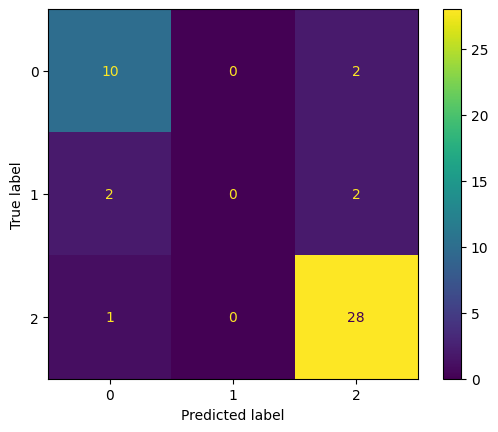

In [262]:
plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
plot.plot()
plt.show()

In [16]:
vocabulary = tfidf_vectorizer.get_feature_names_out()

In [34]:
weights = clf.coef_   # clf är min tränade klassificerare

In [35]:
weights

array([[-0.00335532,  0.00405672, -0.00296049, ...,  0.01066027,
         0.00792541, -0.0026906 ],
       [-0.00294181, -0.00478656, -0.00272883, ..., -0.00451152,
        -0.00243624, -0.00885761],
       [ 0.00629713,  0.00072985,  0.00568932, ..., -0.00614875,
        -0.00548917,  0.01154821]])

In [36]:
def get_n_most_important_words(weights, vocabulary, n):
    indices = np.argpartition(weights, len(weights) - n)[-n:]
    min_elements = weights[indices]
    min_elements_order = np.argsort(min_elements)
    ordered_indices = indices[min_elements_order]
    words = [vocabulary[i] for i in ordered_indices]
    weights = [round(weights[i], 5) for i in ordered_indices]

    return words[::-1], weights[::-1]

In [44]:
print("Top 25 important words for classifying neutral bulletins:")
neutr_words, neutr_weights = get_n_most_important_words(weights[0], vocabulary, 25)
for word, weight in list(zip(neutr_words, neutr_weights)):
    print(f"{word}: {weight}")
print("\nTop 25 important words for classifying female bulletins:")
fem_words, fem_weights = get_n_most_important_words(weights[1], vocabulary, 25)
for word, weight in list(zip(fem_words, fem_weights)):
    print(f"{word}: {weight}")
print("\nTop 25 important words for classifying male bulletins:")
masc_words, masc_weights = get_n_most_important_words(weights[2], vocabulary, 25)
for word, weight in list(zip(masc_words, masc_weights)):
    print(f"{word}: {weight}")

Top 25 important words for classifying neutral bulletins:
financial: 0.3774
art: 0.37713
management: 0.28097
analyst: 0.25598
committee: 0.25569
qualify: 0.25398
animal: 0.2365
graphic: 0.21804
questionnaire: 0.21455
public: 0.21301
expert: 0.20972
degree: 0.19521
relation: 0.19423
recreation: 0.19408
analysis: 0.18755
professional: 0.16166
buyer: 0.15846
utility: 0.15681
business: 0.15255
administration: 0.15081
manager: 0.12759
purchase: 0.12738
accountant: 0.12575
laboratory: 0.12463
risk: 0.1205

Top 25 important words for classifying female bulletins:
volunteer: 0.9277
customer: 0.90618
compensation: 0.47141
accounting: 0.46368
dispatch: 0.36084
representative: 0.33546
telephone: 0.33084
claim: 0.31234
account: 0.29077
worker: 0.28739
coordinator: 0.27027
clerical: 0.25674
radio: 0.23324
bookkeeping: 0.2295
operator: 0.22808
payment: 0.22286
clerk: 0.21524
multiple: 0.2057
billing: 0.20314
assist: 0.1947
center: 0.18966
service: 0.18745
communication: 0.1828
assistant: 0.17593
ste